# **Data Science Basics in Python**

## **Bootstrap for Uncertainty Model**

### **Bootstrap in Python**

Here's a simple workflow, demonstration of bootstrap for modeling workflows. This should help us get started with this important data analytics method to evaluate and intergrate uncertainty for any statistic or model.


 #### **Bootstrap**
 
 Uncertainty in Statistics
 * one source of the uncertainty is the paucity of data
 * do 200 or even less samples provide a precise (and the accurate estimate) of the mean? standard deviation? skew? P13
 
 Would it be useful to know the uncertainty in these statistics due to limited sampling?
 * what is the impact of uncertainty in the mean porosity e.g. 20% +/- 2%?
 * empirically calculate standard deviation errors, confidence interval and to conduct hypothesis testing
 
 **Bootstrap** is a method to assess the uncertainty in statistics by repeated random sampling with replacement to create multiple simulated data sets.

**The Bootstrap Workflow (Efron, 1982)**

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work? Prove it to ourself, for the uncertainty in the mean solution is the standard deviation
$$\sigma^2_{\overline{x}} = \frac{\sigma_s^2}{n}$$

Extremely powerful - could calculate the uncertainty in any statistic! e.g. skew, P13, etc.
* Would not be possible to access any general uncertainty in any statistic without bootstrap.

**Steps**
1. assembling a representative sample or contruct a cumulative distribution function (CDF) using analog data/or declustering weights.
2. For $$\ell = 1,2,\dots, L$$ realizations, do the following:
 * For $i = \alpha, \dots, n$ samples, do the following:
   * Draw a random sample with replacement from the sample set or Monte Carlo simulate from CDF
 * Calculate a realization of the the statistic from the n samples, e.g. $m^{\ell}, \sigma_{\ell}^2$.
3. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method. Let's try it out. But first ...


**Bootstrap Assumptions and Limitations**

* **representativity** - samples are sufficient, representative
* **stationary** -  metric of interest is invariant under translation (identically distribution)
* **no spatial context** - independent samples (no between sample correlation), does not account for boundary of area of interest or local information sources.
* **uncertainty source** - only accounts for uncertainty due to too few samples (no uncertainty due to nonstationarily, multiple population or measurement errors)

**Project Goal**

Learn the basics for working with bootstrap for Uncertainty Modeling in Python to buil pratical spatial data analytics, geostatistics and machine learning workflow.
* Focus on customization and not a survey of available plot times.

**Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import math
import scipy.signal as signal
import random
from scipy.stats import gaussian_kde   # for PDF calculation
from scipy.stats import t              # student's t distribution for analytical solution
import seaborn as sns                  # for advanced plotting

**Convenience Functions for Plotting**

These are convenience functions to visualize the data and bootstrap results.
* **custom_histogram** - data histogram with summary statistics
* **custom_histogram_with_uncert** - data histogram with bootstrap uncertainty model
* **display_bootstrap** - bootstrap realizations' histogram with analytical or empirical PDF

In [28]:
def custom_histogram(zdata, zmin, zmax, xlabel, title):
    offset = (zmax - zmin)/30.0
    freq = plt.hist(zdata, color='red', alpha = 0.3, ec='k', bins=np.linspace(zmin, zmax, int(len(zdata)/3)))[0]
    ht = np.max(freq)
    plt.axvline(x=np.average(zdata), linestyle='--', c='k')
    plt.text(np.average(zdata) + offset, ht*0.95, r'Average = ' + str(round(np.average(zdata),1)), fontsize = 12)
    plt.text(np.average(zdata) + offset, ht*0.90, r'Stdv = ' + str(round(np.std(zdata),1)), fontsize = 12)
    plt.text(np.average(zdata) + offset, ht*0.85, r'P10 = ' + str(round(np.percentile(zdata,10),1)), fontsize = 12)
    plt.text(np.average(zdata) + offset, ht*0.80, r'P90 = ' + str(round(np.percentile(zdata,90),1)), fontsize = 12)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

In [26]:
def custom_histogram_with_uncert(zreal, zmin, zmax, zdata, xlabel, title):
    offset = (zmax - zmin)/30.0
    freq = plt.hist(zdata, color='red', alpha = 0.2, ec='grey', bins=np.linspace(zmin, zmax, int(len(zdata)/3)))[0]
    ht = np.max(freq)
    plt.axvline(x=np.average(zdata), c='k')
    plt.axvline(x=np.percentile(zreal,90), linestyle='--', c='k')
    plt.axvline(x=np.percentile(zreal,10), linestyle='--', c='k')
    plt.text(np.percentile(zreal,90) + offset, ht*0.90, r'Average = ' + str(round(np.average(zreal),1)), fontsize=12)
    plt.text(np.percentile(zreal,90) + offset, ht*0.85, r'Average P90 = ' + str(round(np.percentile(zreal,90),1)), fontsize = 12)
    plt.text(np.percentile(zreal,90) + offset, ht*0.80, r'Average P10 = ' + str(round(np.percentile(zreal,10),1)), fontsize = 12)
    
    plt.xlabel(xlabel); plt.ylabel('Frequency'); plt.title(title)

In [22]:
def display_bootstrap(zreal, zmin, zmax, zdata, title, abin, analytical, stats):
    offset = (zmax - zmin)/30.0
    freq = plt.hist(zreal, color='red', alpha = 0.2, ec='k',
                    bins=np.linspace(zmin, zmax, 100), label='bootstrap', density=True)[0]  # plot the distribution, could also calculate any statistics.
    ht = np.max(freq)
    if analytical is None:
        sns.kdeplot(x=zreal, c='grey', alpha=0.1, levels=1, bw_adjust=1, label='bootstrap PDF')
        plt.xlabel('Bootstrap Realizations and Kernel Density Estimate')
    else:
        plt.plot(abin, analytical, color='black', label='analytical', alpha=0.4)
        plt.fill_between(abin, 0, analytical, where = abin <= np.percentile(zreal,10), facecolor='red', interpolate=True, alpha=0.5)
        plt.fill_between(abin, 0, analytical, where = abin >= np.percentile(zreal,90), facecolor='red', interpolate=True, alpha=0.5)
        plt.xlabel('Bootstrap Realizations and Analytical Sampling Distributions')
    plt.axvline(x=stats(zdata), c='k', linestyle='--')
    plt.text(stats(zdata) + offset, ht*0.95, r'Average = ' + str(round(np.average(zreal),1)), fontsize=12)
    plt.text(stats(zdata) + offset, ht*0.90, r'St.Dev = ' + str(round(np.std(zreal),1)), fontsize=12)
    plt.text(stats(zdata) + offset, ht*0.85, r'P90 = ' + str(round(np.percentile(zreal,90),1)), fontsize = 12)
    plt.text(stats(zdata) + offset, ht*0.80, r'P10 = ' + str(round(np.percentile(zreal,10),1)), fontsize = 12)
    
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(loc='upper left')

**Set the random number seed**

Since we will be random sampling, Monte Carlo simulation for sampling with replacement, we set the random number seed for workflow repeatability
* note, if we rerun any bootstrap code blocks the results will change unless the seed is set in each code block.

In [5]:
seed = 13
random.seed(a=seed)

**Load the Tabular Data**

In [6]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv')
df.head()

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001


**Feature Engineering**

We do just a couple basic things:
* let's drop some samples so that we increase the variations in the bootstrap samples for our demonstration below.
* let's convert porosity from fraction to percentage (100x)

In [7]:
fraction = 0.1                           # set proportion of data to retain and observer the uncertainty
df['Porosity'] = df['Porosity']*100      # convert fraction to percentage
df = df.sample(frac = fraction, random_state = seed)  # extract a random subset
print('Using ' + str(len(df)) + ' number of samples.')


Using 29 number of samples.


**Visualize the DataFrame**


In [8]:
df.head()

,X,Y,Facies,Porosity,Perm
107,390,779,1,19.328012,495.525997
209,530,789,1,15.487071,51.991055
30,800,800,1,12.783107,3.294085
207,450,689,1,15.476265,82.943101
221,490,959,1,19.656596,403.008632


**Calculate the Summary Statistics**

The data includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 is interbedded sand and mudstone), Porosity (percentage), and Permeability as Perm (mDarcy)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,29.0,463.103448,246.520116,20.000000,300.000000,430.000000,550.000000,900.000000
Y,29.0,563.137931,325.808524,89.000000,199.000000,619.000000,839.000000,959.000000
Facies,29.0,0.896552,0.309934,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,29.0,13.943832,3.584357,7.996248,11.684271,12.740454,15.487071,21.821727
Perm,29.0,155.973329,376.973510,0.111985,3.967875,11.806496,98.144295,1954.288198


**Basics Data Visualization Parameters**

Let's see the areal extents (X and Y), feature extents and color map. 

In [10]:
xmin = 0.0; xmax = 1000.0                 # limits for X coordinate
ymin = 0.0; ymax = 1000.0                 # limits for Y coordinate
pormin = 5.0; pormax = 25.0;              # limits for Porosity feature
permmin = 0.01; permmax = 10000           # limits for Permeability feature
cmap = plt.cm.inferno                     # color map

**Basics Data Visualization**

Let's try out location maps, histograms and scatter plot.

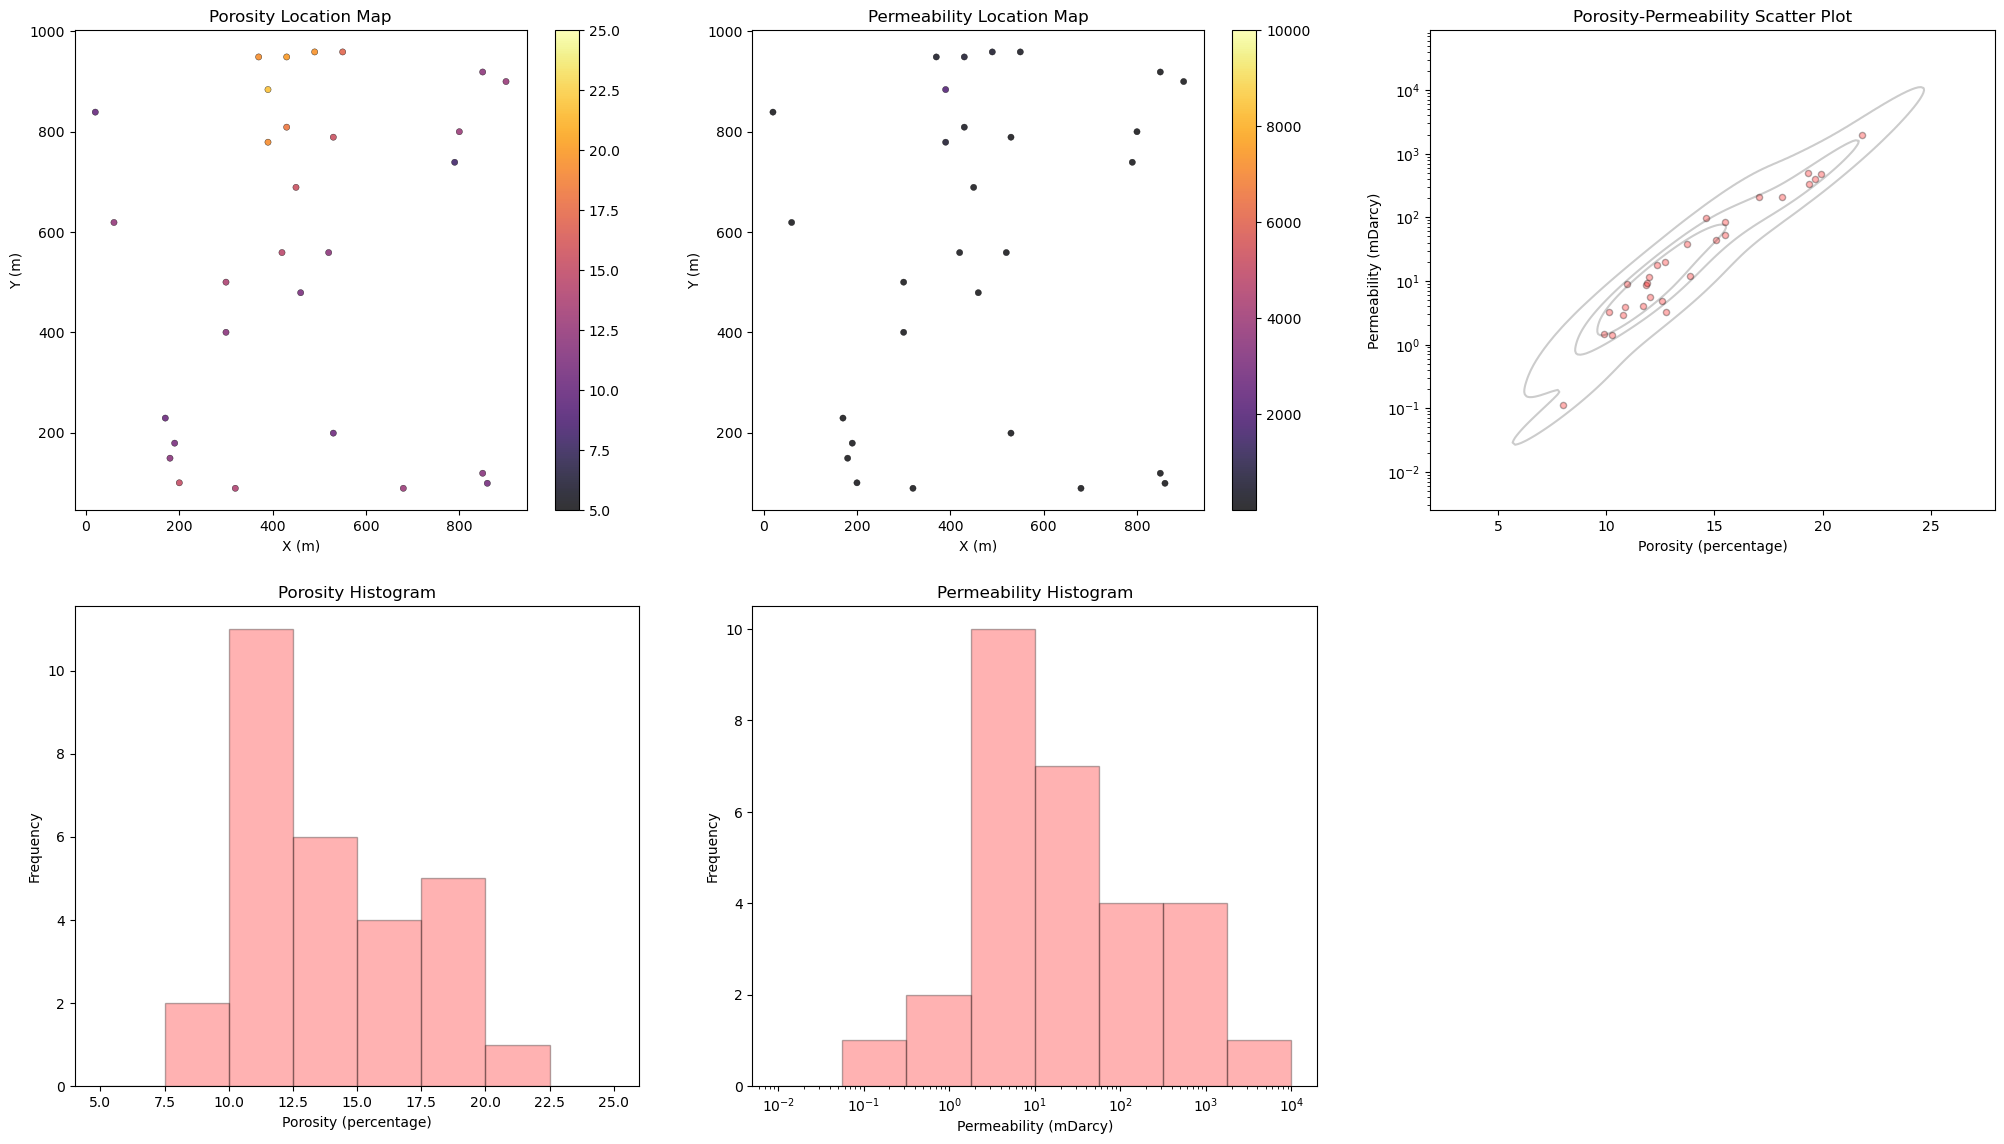

In [11]:
plt.subplot(231)
plt.scatter(df['X'], df['Y'], s=20, c=df['Porosity'],
            cmap = cmap, linewidth=0.3, ec='k', alpha=0.8, vmin=pormin, vmax=pormax)
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Porosity Location Map')


plt.subplot(232)
plt.scatter(df['X'], df['Y'], s=20, c=df['Perm'],
            cmap = cmap, linewidth=0.3, ec='k', alpha=0.8, vmin=permmin, vmax=permmax)
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Permeability Location Map')

plt.subplot(233)
plt.scatter(df['Porosity'], df['Perm'], s=20, c='red', ec='k', alpha=0.3)
plt.xlabel('Porosity (percentage)')
plt.ylabel('Permeability (mDarcy)')
plt.title('Porosity-Permeability Scatter Plot')
plt.yscale('log')
sns.kdeplot(x=df['Porosity'], y=df['Perm'], color='k', alpha=0.2, levels=4)


plt.subplot(234)
plt.hist(df['Porosity'], color='red', alpha=0.3, ec='k', bins = np.linspace(pormin, pormax, int(len(df)/3)))
plt.xlabel('Porosity (percentage)')
plt.ylabel('Frequency')
plt.title('Porosity Histogram')

plt.subplot(235)
plt.hist(df['Perm'], color='red', alpha=0.3, ec='k', bins = np.logspace(np.log10(permmin), np.log10(permmax), int(len(df)/3)))
plt.xlabel('Permeability (mDarcy)')
plt.ylabel('Frequency')
plt.title('Permeability Histogram')
plt.xscale('log')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.2, wspace=0.2, hspace=0.2)
plt.show()

**Bootstrap Method in Python**

Workflow for Bootstrap in Python
* specify the number of bootstrap realizations $L$
* declare a list to store the bootstrap realizations of the statistics of interest
* loop over the $L$ realizations:
  * $n$ MCS, random samples with replacement for a new realization of the data
  * calculate the realization of the statistic from the realization of the data
* summarize the resulting uncertainty model, histogram and summary statistics, etc.

**Bootstrap of the Sample Mean, Arithmetic Average**

Let's make a simple bootstrap function where:
* **zdata** is a 1D ndarray of the original data
* **nreal** is the number of bootstrap realizatons to calculate
* **stats** is function to calculates the statistics

In [12]:
def bootstrap(zdata, nreal, stats):
    zreal = []                           # declare an empty list to store the bootstrap realizations
    for i in range(0,nreal):             # Loop over the L bootstrap realizations
        samples = random.choices(zdata, k=len(zdata))    # n Monte Carlo simulations, sample with replacement
        zreal.append(stats(samples))                     # calculate the realization of the statistic and append to list
    return zreal                                         # return the list of realizations of the statistic
    

**Additional Declarations for Readable Code**

Let's add a couple more declarations for concise, readable code

In [13]:
por = df['Porosity'].values                    # copy the Data series, Porosity feature, to 1D array
lpor = np.linspace(pormin, pormax, 100)        # calculate bins for plotting


**Demonstration of Bootstrap for Uncertainty in the Mean**

Let's bootstrap to calculate the uncertainty in the mean. We will compare the bootstrap result with the analytical expression:
$$\mu \sim \overline{x} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{s^2}{n}}$$

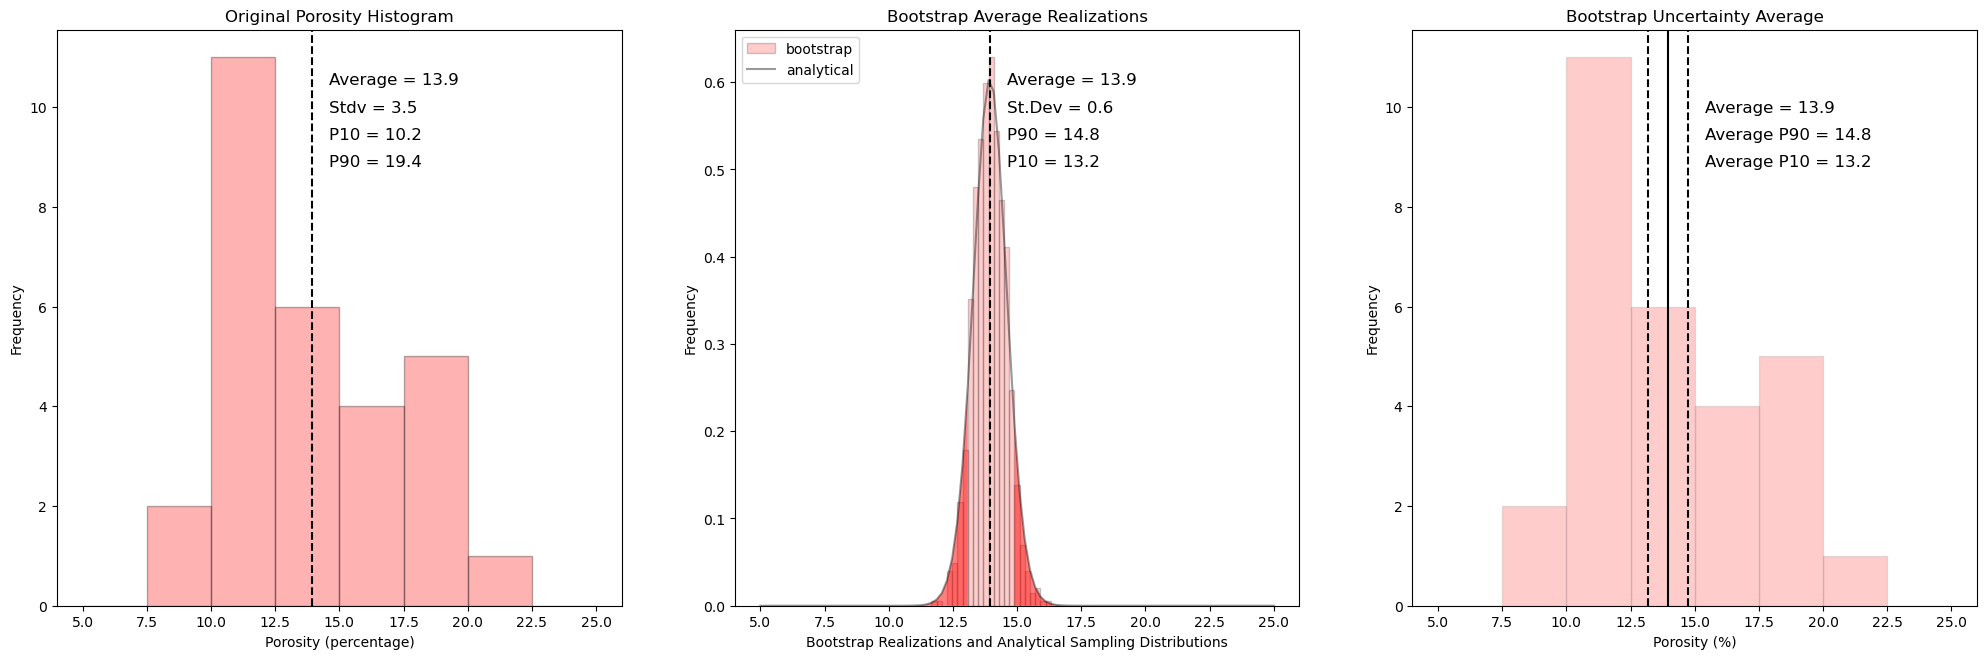

In [29]:
L = 1000; random.seed(a=seed)
por_avg_real = bootstrap(por,L,np.average)  # bootstrap of the arithmetic average

plt.subplot(131)
custom_histogram(por, pormin, pormax, 'Porosity (percentage)', 'Original Porosity Histogram')

plt.subplot(132)
mod = t.pdf(lpor, len(df)-1, loc=np.average(por), scale=math.sqrt(np.var(por)/len(df)))  # analytcal PDf
display_bootstrap(por_avg_real, pormin, pormax, por, 'Bootstrap Average Realizations', lpor, mod, np.average)

plt.subplot(133)
custom_histogram_with_uncert(por_avg_real, pormin, pormax, por, 'Porosity (%)', 'Bootstrap Uncertainty Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

**Write out the Bootstrap Samples for the Uncertainty in the Mean**

Set the file name and the feature name and write my bootstrap realizations as .csv file.
 * file will be written in the current working directory

In [15]:
filename = 'avg_por_boost.cvs'
featurename = 'avg_por_boost'

df_boost = pd.DataFrame(data=por_avg_real, columns=[featurename])   # DataFrame with the bootstrap realizations
df_boost.to_csv(filename, index=False)
df_boost.head()

,avg_por_boost
0,13.505598
1,13.896181
2,13.771810
3,13.872079
4,14.120102


**Demonstrate of Bootstrap for Uncertainty in the Standard Deviation**

Let's perform bootstrap of a measure of dispersion, the standard deviation, $\sigma_x$

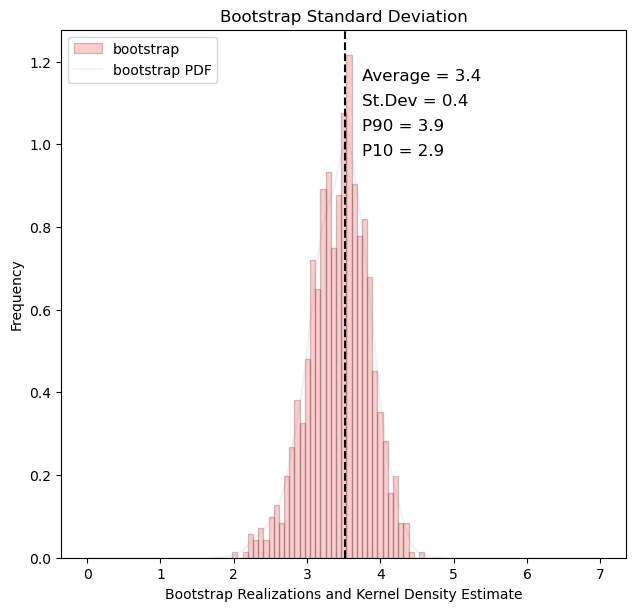

In [24]:
L = 1000; random.seed(a=seed)
por_stdev_real = bootstrap(por,L,np.std)

plt.subplot(131)
display_bootstrap(por_stdev_real, 0, 7, por, 'Bootstrap Standard Deviation', lpor, None, np.std)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

**Bootstrap of the Coefficient Variation**

Here's the statistic that is derived from multiple statistics for each bootstrap realization of the data.
* $CV_x^{\ell} = \frac{s_x^{\ell}}{\overline{x}_x^{\ell}}$
* this reinforces that we bootstrap dataset realizations and then calculate the statistic on this dataset realization

For coefficient of variation we will
* calculate a bootstrap realization of the dataset with $n$ samples with replacement.
* calculate the mean and standard deviation from this bootstrapped realization of the dataset
* calculate a bootstrap realization of the coefficient of variations as the standard deviation realization divided by the mean realization

Repeating that $L$ time on $L$ realizations of the data and then evaluate the resulting distribution

**Demonstration of Bootstrap for Uncertainty in the Coefficient of Variation**

Now bootstrap uncertainty of coefficient of variation, $CV_x^{\ell} = \frac{s_x^{\ell}}{\overline{x}_x^{\ell}}$

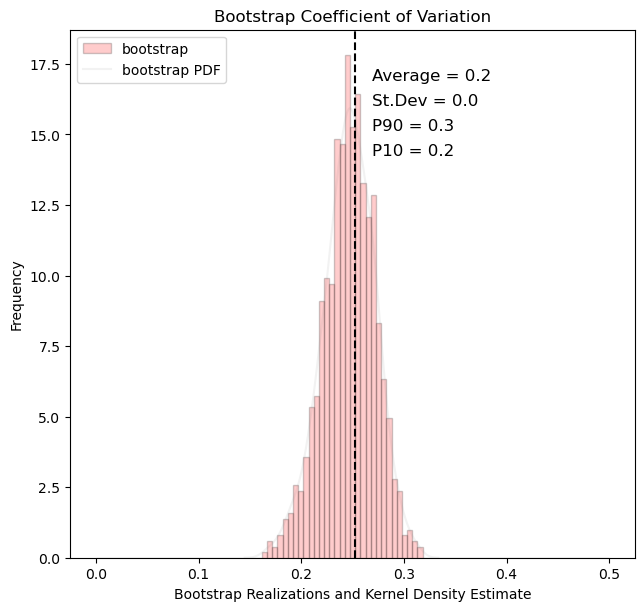

In [32]:
cv = lambda x: np.std(x)/np.mean(x)     # define the lambda function to calculate the coefficient of variation
L = 1000; random.seed(a=seed)           # set the number and seed for bootstrap realization
por_cv_real = bootstrap(por,L,cv)       # bootstrap of the interquartile range

plt.subplot(131)
display_bootstrap(por_cv_real,0,0.5, por, 'Bootstrap Coefficient of Variation', lpor, None, cv)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

**Demonstration of Bootstrap for Uncertainty in the Interquartile Range**

Here's another statistic that is derived from a combination of statistics, interquartile range, $IQR_x^{\ell} = F_x^{\ell}(0.75) - F_x^{\ell}(0.25)$

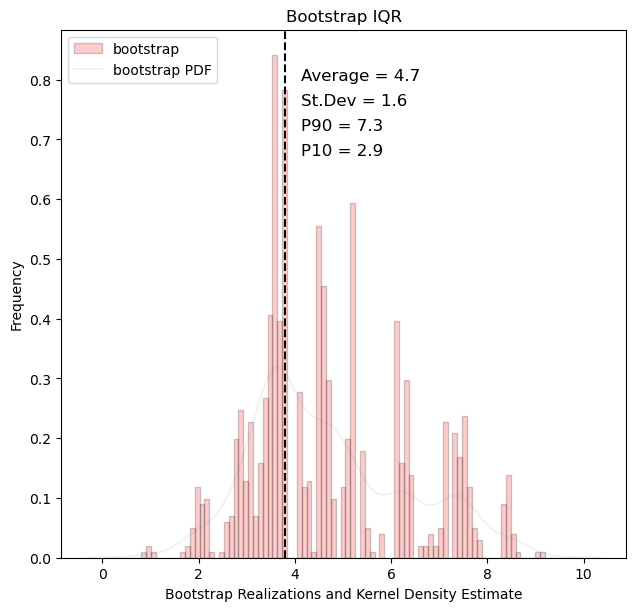

In [35]:
L = 1000; random.seed(a=seed)
por_iqr_real = bootstrap(por,L,stats.iqr)

plt.subplot(131)
display_bootstrap(por_iqr_real, 0,10,por,'Bootstrap IQR',lpor,None,stats.iqr)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1.1, wspace=0.2, hspace=0.2)
plt.show()

**Demonstration of Bootstrap for Uncertainty in the Percentile**

Now let's select any percentile and bootstrap it.

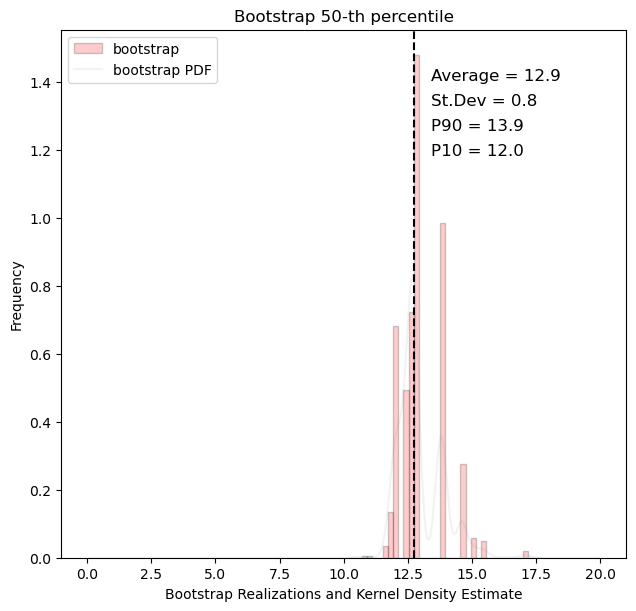

In [36]:
percentile = 50
def my_percentile(data):
    return np.percentile(data,percentile)

L=1000; random.seed(a=seed)
por_per_real = bootstrap(por,L,my_percentile)

plt.subplot(131)
display_bootstrap(por_per_real, 0,20,por, 'Bootstrap ' + str(percentile) + '-th percentile', lpor, None, my_percentile)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1.1, wspace=0.2, hspace=0.2)
plt.show()

**Demonstration of Bootstrap for Uncertainty in the Proportion**

Let's demonstrate another case for which we have the analytical solution to check our bootstrap result
$$P \sim \hat{p} \pm t_{\frac{\alpha}{2},n-1}\sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}$$

In [37]:
def proportion_bootstrap_viz(zdata,nreal,nbin):
    sand_prop_real = []                       # declare an empty list to store the bootstrap realizations of the statistic 
    shale_prop_real = []
    
    for k in range(0,L):                      # loop over the L bootstrap realizations
        samples = random.choices(zdata, k=len(zdata)) # n Monte Carlo simulations
        sand_prop_real.append(samples.count(1)/len(zdata)) # calculate the statistic of interest from the new bootstrap dataset
        shale_prop_real.append(samples.count(0)/len(zdata)) # calculate the statistic of interest from the new bootstrap dataset       
    sand_prop = np.sum(zdata == 1)/len(zdata); shale_prop = np.sum(zdata == 0)/len(df)
    
    fig = plt.subplot(121) 
    barlist = plt.bar(x=['shale','sand'],height = [1-sand_prop,sand_prop],color = 'red',alpha = 0.3,edgecolor='black')
    barlist[0].set_color('blue')
    plt.text(-.3, shale_prop+0.02, r'Prop. Shale = ' + str(round(shale_prop,2)), fontsize=12)
    plt.text(0.7, sand_prop+0.02, r'Prop. Sand = ' + str(round(sand_prop,2)), fontsize=12)
    plt.xlabel('Rock Type / Facies'); plt.ylabel('Frequency'); plt.title('Facies Histogram')
    plt.ylim([0,1]); plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.subplot(122)     
    plt.hist(sand_prop_real,color = 'red',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,nbin),label = 'sand',density = True) # plot the distribution, could also calculate any summary statistics
    analytical = t.pdf(np.linspace(0.0,1.0,200), len(df)-1,loc=sand_prop,scale=math.sqrt(sand_prop*(1.0-sand_prop)/len(df)))
    plt.plot(np.linspace(0.0,1.0,200),analytical,color = 'black',label = 'analytical',alpha=0.4)
    plt.axvline(x=sand_prop,linestyle="--",c='black')
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical, where = np.linspace(0.0,1.0,200) <= np.percentile(sand_prop_real,10), facecolor='red', interpolate=True, alpha = 0.5)
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical, where = np.linspace(0.0,1.0,200) >= np.percentile(sand_prop_real,90), facecolor='red', interpolate=True, alpha = 0.5)
    plt.text(np.average(sand_prop_real)-0.3, 7.0, r'E{Prop.} = ' + str(round(sand_prop,2)), fontsize=12)
    plt.text(np.average(sand_prop_real)-0.3, 6.6, r'P90 = ' + str(round(np.percentile(sand_prop_real,90),2)), fontsize=12)
    plt.text(np.average(sand_prop_real)-0.3, 6.2, r'P10 = ' + str(round(np.percentile(sand_prop_real,10),2)), fontsize=12)
    
    plt.hist(shale_prop_real,color = 'blue',alpha = 0.2,edgecolor = 'black',bins=np.linspace(0.0,1.0,nbin),label = 'shale',density = True) # plot the distribution, could also calculate any summary statistics
    analytical_shale = t.pdf(np.linspace(0.0,1.0,200), len(df)-1,loc=shale_prop,scale=math.sqrt(shale_prop*(1.0-shale_prop)/len(df)))
    plt.plot(np.linspace(0.0,1.0,200),analytical_shale,color = 'black',alpha=0.4)
    plt.axvline(x=shale_prop,linestyle="--",c='black')
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical_shale, where = np.linspace(0.0,1.0,200) <= np.percentile(shale_prop_real,10), facecolor='blue', interpolate=True, alpha = 0.5)
    plt.fill_between(np.linspace(0.0,1.0,200), 0, analytical_shale, where = np.linspace(0.0,1.0,200) >= np.percentile(shale_prop_real,90), facecolor='blue', interpolate=True, alpha = 0.5)
    plt.text(np.average(shale_prop_real)+0.07, 7.0, r'E{Prop.} = ' + str(round(shale_prop,2)), fontsize=12)
    plt.text(np.average(shale_prop_real)+0.07, 6.6, r'P90 = ' + str(round(np.percentile(shale_prop_real,90),2)), fontsize=12)
    plt.text(np.average(shale_prop_real)+0.07, 6.2, r'P10 = ' + str(round(np.percentile(shale_prop_real,10),2)), fontsize=12)
    
    plt.xlabel('Boostrap Realizations and Analytical Sampling Distributions'); plt.ylabel('Frequency'); plt.title('Distribution of Bootstrap Proportions')
    plt.legend(loc = 'upper left')
    
    return sand_prop_real, shale_prop_real

**Demonstration of Bootstrap for Uncertainty in the Proportion**

Here's the original facies, categorical feature normalized histogram and bootstrap uncertainty in proportions.
* given enough bootstrap realizations, we have a good match with the analytical prediction.

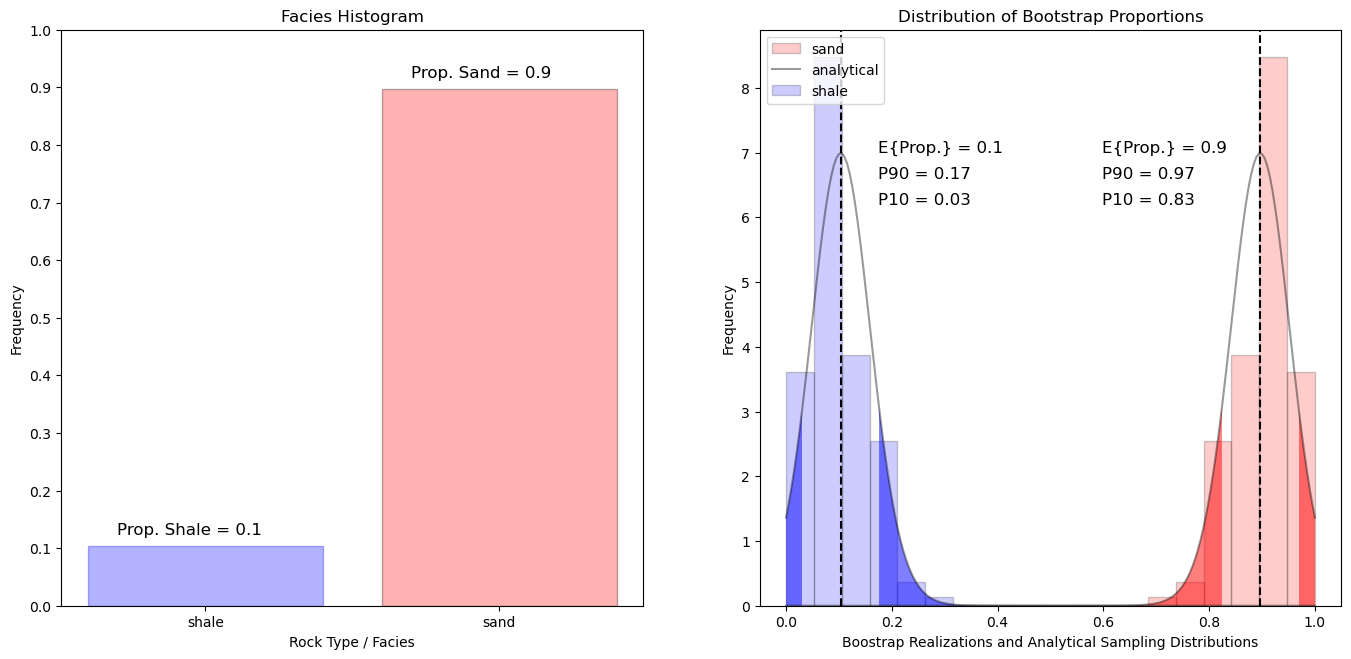

In [38]:
sand_prop_real, shale_prop_real = proportion_bootstrap_viz(zdata=df['Facies'].values, nreal=10000, nbin=20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

**Optional: Write out the Bootstrap Samples for an Uncertainty in the Proportion Model**

Set the file name and feature name and write our bootstrap realization as a .csv file
* file will be written in the current directory

In [40]:
filename2 = 'prop_facies_boot.csv'
featurename2 = ['sand_prop_boot', 'shale_prop_boot']

df_prop_boot = pd.DataFrame(data = np.column_stack((sand_prop_real,shale_prop_real)), columns=[featurename2])
df_prop_boot.to_csv(filename2, index=False)